In [166]:
import os
import sys
import getpass
import math

from omero import model, grid
from omero import rtypes
from omero import ClientError
from omero import sys as om_sys
from omero import constants
from pyomero_upload.pyomero_upload import PyOmeroUploader

from omero.util.script_utils import readFlimImageFile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# configure connection settings
server = 'demo.openmicroscopy.org'
user = 'jhay'
password = getpass.getpass()

········


In [155]:
proj_ids, dataset_ids, annotation_ids, image_ids = list(), list(), list(), list()
params = om_sys.Parameters()
# LINKED_ANNOS_BY_PROJ_QUERY = "select p from Project p left outer join  \
#                              fetch p.annotationLinks as links left outer join fetch  \
#                              links.child as annotation where p.id=:pid"
# LINKED_ANNOS_BY_DS_QUERY = "select d from Dataset d left outer join  \
#                             fetch d.annotationLinks as links left outer join fetch  \
#                             links.child as annotation where d.id=:did"
# LINKED_DATASETS_BY_PROJ_QUERY = "select p from Project p left outer join  \
#                                fetch p.datasetLinks as links left outer join fetch  \
#                                links.child as dataset where p.id=:pid"
LINKED_ANNOS_BY_PROJ_QUERY = "select link.child from ProjectAnnotationLink link where link.parent.id = :pid"
LINKED_DATASETS_BY_PROJ_QUERY = "select link.child from ProjectDatasetLink link where link.parent.id = :pid"
LINKED_ANNOS_BY_DS_QUERY = "select link.child from DatasetAnnotationLink link where link.parent.id = :did"
LINKED_IMAGES_BY_DS_QUERY = "select link.child from DatasetImageLink link where link.parent.id = :did"
LINKED_ANNOS_BY_IMG_QUERY = "select link.child from ImageAnnotationLink link where link.parent.id = :iid"
ALL_PROJ_QUERY = "select p from Project p"

# Retrieve objects by associated project ID
DATASETS_BY_PROJECT_QUERY = "select d from Dataset d left outer join fetch d.projectLinks as plinks \
             left outer join fetch plinks.child as dataset where plinks.parent.id = :pid"

# Retrieve objects by associated dataset ID
IMAGES_BY_DATASET_QUERY = "select i from Image i left outer join fetch i.datasetLinks as dlinks \
             left outer join fetch dlinks.child as image where dlinks.parent.id = :did"

# Find objects by tag text
PROJECTS_BY_TAG_QUERY = "select p from Project p left outer join fetch p.annotationLinks as alinks \
             left outer join fetch alinks.child as annotation where alinks.child.textValue like :anno_text"

DATASETS_BY_TAG_QUERY = "select d from Dataset d left outer join fetch d.annotationLinks as alinks \
             left outer join fetch alinks.child as annotation where alinks.child.textValue like :anno_text"

IMAGES_BY_TAG_QUERY = "select i from Image i left outer join fetch i.annotationLinks as alinks \
             left outer join fetch alinks.child as annotation where alinks.child.textValue like :anno_text"

# Retrieve pixels for images by IDs
PIXELS_BY_IMAGE_QUERY = "SELECT p FROM Pixels as p JOIN FETCH p.image JOIN FETCH p.pixelsType \
             WHERE p.image.id in :iids"
#link.parent from DatasetAnnotationLink link where link.child.textValue = :text"
#"select p from Project p left outer join fetch p.datasetLinks as links left
#            outer join fetch links.child as dataset where p.id=:pid"

In [183]:
'''
N.B.: Rerun this cell if your connection to the OMERO server has timed-out
'''
uploader = PyOmeroUploader(user, password, server)
searcher = uploader.searcher()

In [19]:
'''
Find datasets with a given ID and name
'''
# query = "select d from Dataset d where d.name = :dname"
# query = "select d from Dataset d where d.id = :did"
query = "select d from Dataset d where d.id = :did and d.name = :dname"

params = om_sys.Parameters()
dataset_name = "Upload from Jupyter2"
dId = 3804
# params.map = {'did' : rtypes.rlong(dId)}
# params.map = {'dname' : rtypes.rstring(dataset_name)}
params.map = {'did' : rtypes.rlong(dId), 'dname' : rtypes.rstring(dataset_name)}

datasets = searcher.find_objects_by_query(query, params)

In [20]:
dataset = datasets[0]
print dataset.name.val

Upload from Jupyter2


In [97]:
'''
Run queries to search for objects with tag annotations containing given text
SQL 'Like' queries are achieved with '%' for wildcard characters
'''
params = om_sys.Parameters()
tag_text = "%Bat%"
params.map = {'anno_text' : rtypes.rstring(tag_text)}

projects = searcher.find_objects_by_query(PROJECTS_BY_TAG_QUERY, params)
datasets = searcher.find_objects_by_query(DATASETS_BY_TAG_QUERY, params)
images = searcher.find_objects_by_query(IMAGES_BY_TAG_QUERY, params)

In [98]:
for project in projects:
    print project.name.val

for dataset in datasets:
    print dataset.name.val

for anno in dataset.linkedAnnotationList():
    print anno.textValue.val

for image in images:
    print image.name.val

Johnny Test Project
upload_test
Upload from Jupyter2
Batgirl
pos001


In [189]:
'''
Find child objects using a project ID
'''
params = om_sys.Parameters()
project_id = '1642'
params.map = {'pid' : rtypes.rlong(project_id)}

datasets = searcher.find_objects_by_query(DATASETS_BY_PROJECT_QUERY, params)

image_id_list = []

for dataset in datasets:
    dataset_id = dataset.id.val
    print dataset_id
    params.map = {'did' : rtypes.rlong(dataset_id)}
    images = searcher.find_objects_by_query(IMAGES_BY_DATASET_QUERY, params)
    
    for image in images:
        image_id_list.append(image.id.val)

2928
2929


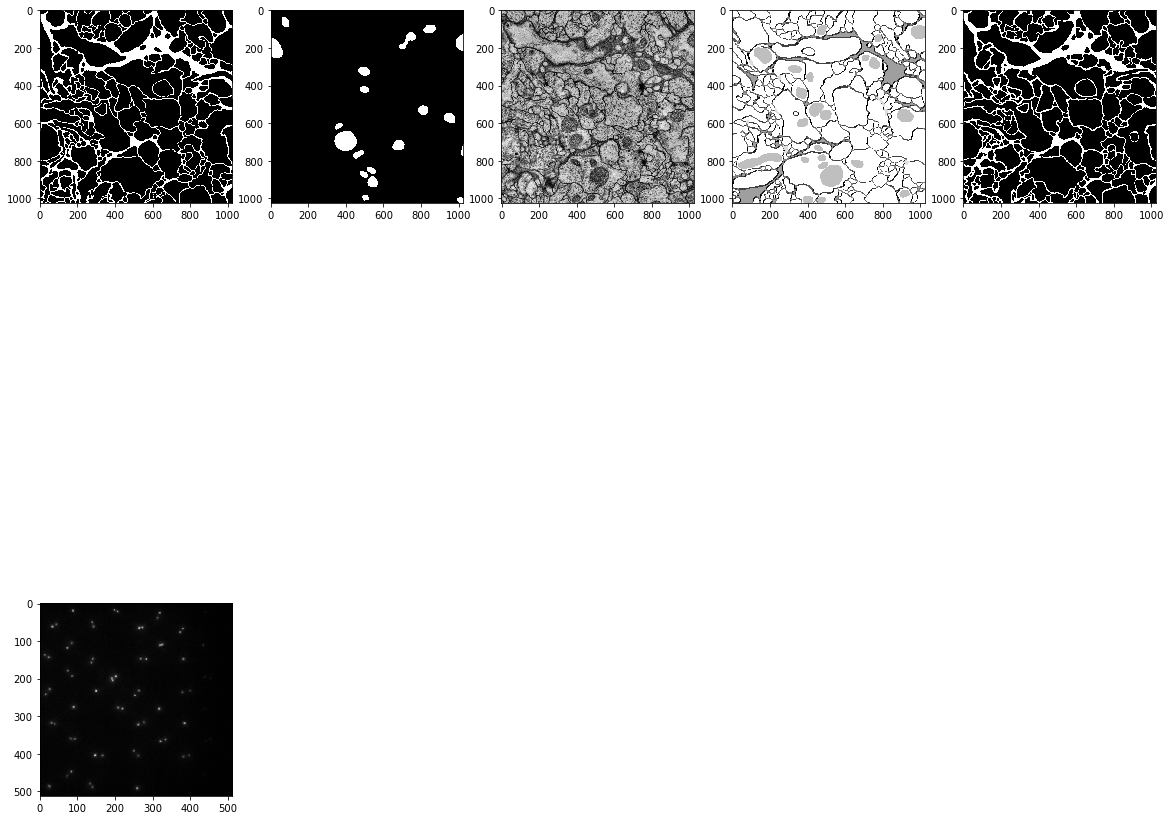

In [187]:
# retrieve pixels by Image ID
image_id_list = [95279, 111608, 95309, 95323, 95299, 95317]
image_ids = map(rtypes.rlong, image_id_list)
params.map = {'iids' : rtypes.rlist(image_ids)}
pixels_list = searcher.find_objects_by_query(PIXELS_BY_IMAGE_QUERY, params)

image_stacks = []

for pixels in pixels_list:
    # see https://github.com/ome/openmicroscopy/blob/v5.4.10/components/tools/OmeroPy/src/omero/util/script_utils.py
    raw_pixels_store = searcher.SESSION.createRawPixelsStore()
    stack = readFlimImageFile(raw_pixels_store, pixels)
    image_stacks.append(stack[0, :, :])

# create a grid layout to display images with maximum of 5 per row
rows = int(math.ceil(float(len(image_id_list))/float(5)))
columns = min([len(image_id_list), 5])

h, w = 20, 20
fig=plt.figure(figsize=(h,w))
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
for idx, image_stack in enumerate(image_stacks):
    fig.add_subplot(rows, columns, idx+1)
    imgplot = plt.imshow(image_stack, cmap='gray')

plt.show()

In [216]:
def open_omero_session():
    global SESSION

    try:
        SESSION = CLIENT.getSession()
        return
    except ClientError as e:
        print "No live session"
        
    SESSION = CLIENT.createSession(USERNAME, PASSWORD)

In [217]:
def close_omero_session():
    CLIENT.closeSession()

In [218]:
def destroy_omero_session():
    CLIENT.destroySession(CLIENT.getSessionId())

In [219]:
def find_objects_by_query(query, params, all=False):
    global SESSION
    queryService = SESSION.getQueryService()
    # query = "\"select p from Project p left outer join fetch p.datasetLinks as links left outer join fetch links.child as dataset where p.id =:pid\""
    objects = list()
    if all == False:
        objects = queryService.findByQuery(query, params)
    else:
        objects = queryService.findAllByQuery(query, params)
    return objects

In [220]:
def print_comment_divider():
    print "########################################################################################"
    print "###################--------------------------------------------#########################"
    print "########################################################################################"

global SESSION
try:
    close_omero_session()
    destroy_omero_session()
except Exception as e:
    print "Existing session"
    
try:
    SESSION = None
    open_omero_session()
except Exception as e:
    print "Existing session"
    
print SESSION

Existing session
No live session
session-1dae3b06-4cb4-473d-b272-c4dfc95c473e/d6bb8df6-5b8c-4991-af88-bff4583b5269 -t -e 1.0 @ BlitzAdapters


In [221]:
%%timeit
## time to get projects
global params
params.map = dict()
all_projs = find_objects_by_query(ALL_PROJ_QUERY, params, True)
# print all_projs
global proj_ids
#     return all_projs
proj_ids = [i.id.val for i in all_projs]
proj_ids = list(set(proj_ids))  # remove any duplicates

10 loops, best of 3: 75 ms per loop


In [222]:
%%timeit
# Get LinkedDatasets for Projects
global dataset_ids
global proj_ids
dataset_ids = list()

for proj_id in proj_ids:
    params.map = {"pid": rtypes.rlong(proj_id)}
    proj_datasets = find_objects_by_query(LINKED_DATASETS_BY_PROJ_QUERY, params, True)
    ds_ids = [i.id.val for i in proj_datasets]
    ds_ids = list(set(ds_ids))  # remove any duplicates
#     print ds_ids
    dataset_ids.extend(ds_ids)

10 loops, best of 3: 74.7 ms per loop


In [227]:
%%timeit
# Get LinkedAnnotations for Datasets
global annotation_ids
global dataset_ids
annotation_ids = list()

for ds_id in dataset_ids:
    params.map = {"did": rtypes.rlong(ds_id)}
    ds_annos = find_objects_by_query(LINKED_ANNOS_BY_DS_QUERY, params, True)
    anno_ids = [i.id.val for i in ds_annos]
    anno_ids = list(set(anno_ids))  # remove any duplicates
#     print anno_ids
    annotation_ids.extend(anno_ids)
annotation_ids = list(set(annotation_ids))  # remove any duplicates

10 loops, best of 3: 145 ms per loop


In [228]:
%%timeit
# Get LinkedAnnotations for Datasets
global image_ids
global dataset_ids
image_ids = list()

for ds_id in dataset_ids:
    params.map = {"did": rtypes.rlong(ds_id)}
    ds_images = find_objects_by_query(LINKED_IMAGES_BY_DS_QUERY, params, True)
    img_ids = [i.id.val for i in ds_images]
    img_ids = list(set(img_ids))  # remove any duplicates
#     print anno_ids
    image_ids.extend(img_ids)

1 loop, best of 3: 270 ms per loop


In [229]:
%%timeit
# Get LinkedAnnotations for Datasets
global annotation_ids
global image_ids

for img_id in image_ids:
    params.map = {"iid": rtypes.rlong(img_id)}
    img_annos = find_objects_by_query(LINKED_ANNOS_BY_IMG_QUERY, params, True)
    anno_ids = [i.id.val for i in img_annos]
    anno_ids = list(set(anno_ids))  # remove any duplicates
#     print anno_ids
    annotation_ids.extend(anno_ids)
annotation_ids = list(set(annotation_ids))  # remove any duplicates

1 loop, best of 3: 7.47 s per loop


In [230]:
global dataset_ids, annotation_ids, image_ids
print dataset_ids
print annotation_ids
print image_ids
# https://github.com/openmicroscopy/omero-example-scripts/blob/master/metadata_scripts/Metadata_Search.py
# close_omero_session()
# destroy_omero_session()

[2928L, 2929L]
[4324L, 4325L, 4326L, 4327L, 4328L, 4329L]
[95236L, 95237L, 95238L, 95239L, 95240L, 95241L, 95242L, 95243L, 95244L, 95245L, 95246L, 95247L, 95248L, 95249L, 95250L, 95251L, 95252L, 95253L, 95254L, 95255L, 95256L, 95257L, 95258L, 95259L, 95260L, 95261L, 95262L, 95263L, 95264L, 95265L, 95266L, 95267L, 95268L, 95269L, 95270L, 95271L, 95272L, 95273L, 95274L, 95275L, 95276L, 95277L, 95278L, 95279L, 95280L, 95281L, 95282L, 95283L, 95284L, 95285L, 95286L, 95287L, 95288L, 95289L, 95290L, 95291L, 95292L, 95293L, 95294L, 95295L, 95296L, 95297L, 95298L, 95299L, 95300L, 95301L, 95302L, 95303L, 95304L, 95305L, 95306L, 95307L, 95308L, 95309L, 95310L, 95311L, 95312L, 95313L, 95314L, 95315L, 95316L, 95317L, 95318L, 95319L, 95320L, 95321L, 95322L, 95323L, 95324L, 95325L, 95326L, 95327L, 95328L, 95329L, 95330L, 95331L, 95332L, 95333L, 95334L, 95335L]
